In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os

import shap

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score

In [4]:
# Preparando o dataset
diretorio = 'heart+disease'

arquivos = os.listdir(diretorio)
arquivos = [arquivo for arquivo in arquivos if arquivo.startswith('processed.') and arquivo.endswith('.data')]

datasets = []
for arquivo in arquivos:
    dataset = pd.read_csv(os.path.join(diretorio, arquivo), header=None)
    datasets.append(dataset)

# Concatenando os datasets
dataset = pd.concat(datasets, ignore_index=True)

dataset.columns = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"]

dataset.sample(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
521,55.0,1.0,4.0,140,201,0,0,130,1,3.0,2,?,?,1
320,36.0,1.0,3.0,112,340,0,0,184,0,1.0,2,?,3,0
567,52.0,1.0,4.0,160,246,0,1,82,1,4.0,2,?,?,1
11,56.0,0.0,2.0,140.0,294.0,0.0,2.0,153.0,0.0,1.3,2.0,0.0,3.0,0
817,62.0,1.0,1.0,112,258,0,1,150,1,?,?,?,?,1


---
-  Analisando o dataset

In [6]:
dataset['target'].value_counts()

target
0    411
1    265
2    109
3    107
4     28
Name: count, dtype: int64

In [7]:
df = dataset.copy()

print (df.shape)
# excluindo linhas que tenham ao menos valor ?
df = df.replace('?', np.nan)
df.dropna(inplace=True)

print (df.shape)

(920, 14)
(299, 14)


- Não tem como minimamente excluir as linhas que apreentam "?". Vai excluir muitas linhas e tem uma perda grande. 
- Assim, vamos tentar fazer um preenchimento artificial, porém inteligente desses valores faltantes. 
- Vamos utilizar a biblioteca "".

In [8]:
knn_inputer = KNNImputer(n_neighbors=10, weights='uniform', metric='nan_euclidean')

df = dataset.copy()
df = df.replace('?', np.nan)
df = df.astype(float)
df_inputed = knn_inputer.fit_transform(df)

df = pd.DataFrame(df_inputed, columns=df.columns)
df['target'] = df['target'].astype(int)
df.sample(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
136,70.0,1.0,4.0,145.0,174.0,0.0,0.0,125.0,1.0,2.60,3.0,0.0,7.0,4
676,60.0,1.0,4.0,130.0,0.0,0.1,1.0,130.0,1.0,1.10,3.0,1.0,6.8,1
326,37.0,1.0,2.0,130.0,283.0,0.0,1.0,98.0,0.0,0.00,2.2,1.4,5.8,0
733,63.0,1.0,3.0,130.7,0.0,0.0,2.0,123.0,0.4,0.85,2.0,1.0,5.8,1
882,57.0,1.0,4.0,156.0,173.0,0.0,2.0,119.0,1.0,3.00,3.0,1.1,6.3,3


---
- Vamos preparar o dataset para treinamento e teste

In [27]:
df_train = df.copy().drop(columns=['target'])
df_test = df.copy()['target']

scaler = StandardScaler()
df_train = scaler.fit_transform(df_train)

x_train, x_test, y_train, y_test = train_test_split(df_train, df_test, test_size=0.35, stratify=df_test)

print (f'{x_train.shape=}\n{x_test.shape=}\n{y_train.shape=}\n{y_test.shape=}')

x_train.shape=(598, 13)
x_test.shape=(322, 13)
y_train.shape=(598,)
y_test.shape=(322,)


<Axes: title={'center': 'Distribuição de classes no teste'}, xlabel='Classes', ylabel='Frequência'>

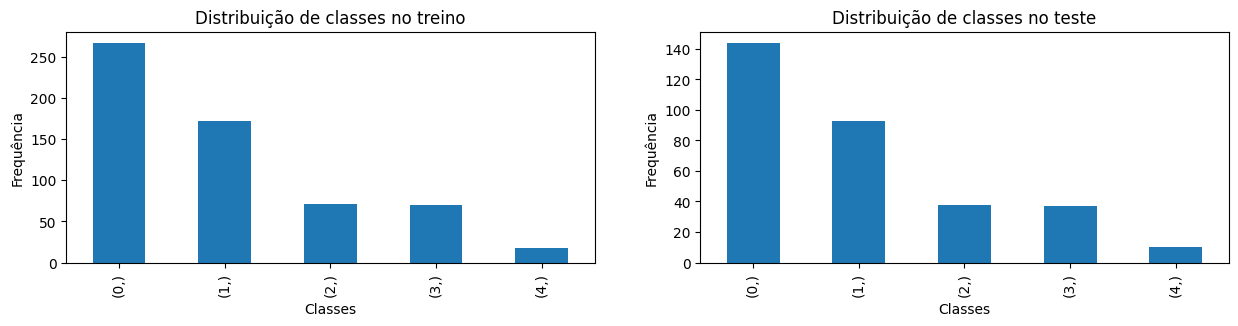

In [10]:
grafico = plt.figure(figsize=(15, 3))

grafico.add_subplot(1, 2, 1)
pd.DataFrame(y_train).value_counts().plot(kind='bar', title='Distribuição de classes no treino', xlabel='Classes', ylabel='Frequência')

grafico.add_subplot(1, 2, 2)
pd.DataFrame(y_test).value_counts().plot(kind='bar', title='Distribuição de classes no teste', xlabel='Classes', ylabel='Frequência')

In [29]:
print (y_test.value_counts())

target
0    144
1     93
2     38
3     37
4     10
Name: count, dtype: int64


Accuracy: 0.59


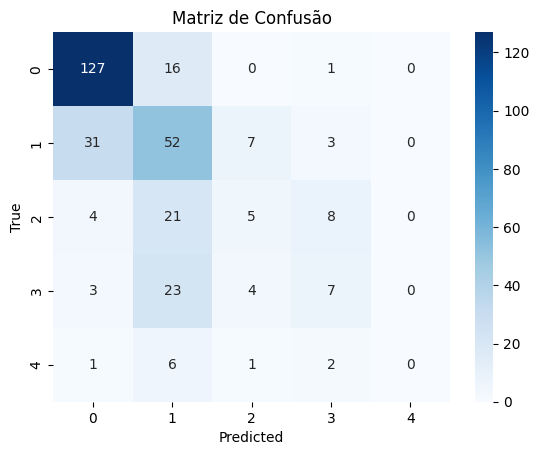

In [30]:
model = RandomForestClassifier(n_estimators=200, class_weight='balanced')
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print (f'Accuracy: {accuracy:.2f}')

confusion = confusion_matrix(y_test, y_pred)

sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão')
plt.show()

- Muito ruim. Ficou muito baixa a performance do modelo Random Forest

---
- Utilizando modelo knn

Accuracy: 0.60


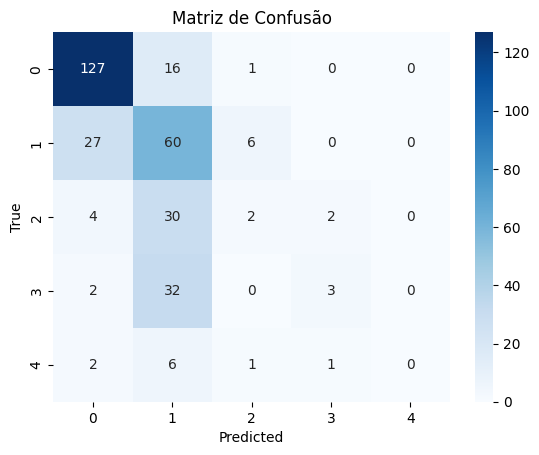

In [31]:
model = KNeighborsClassifier(n_neighbors=15, weights='uniform', metric='nan_euclidean')
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print (f'Accuracy: {accuracy:.2f}')

confusion = confusion_matrix(y_test, y_pred)

sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão')
plt.show()

- O dataset está muito desbalanceado. Vamos tentar duas alternativas:
- 1ª) Remover várias instâncias das classes dominantes para ver se os modelos ficam menos insensíveis com as classes minoritárias;
- 2ª) Utilizar bibliotecas que criam instâncias "falsas" para a classe minoritária e ver se aumenta a sensibilidade desta;